In [1]:
#### NOTE: These are imports I use (some redundant), please remove as necessary
import sys # system commands
import string as string # string functions4
import math
import numpy as np # numerical tools
from scipy import *
from pylab import *
import os
import itertools
import math as maths
from scipy import integrate
from scipy.stats import distributions,pearsonr,chisquare,norm
from scipy.optimize import curve_fit, minimize,fmin, fmin_powell, root
from scipy import interpolate
from scipy.signal import lfilter
from scipy.interpolate import interp1d,RectBivariateSpline
from scipy.misc import derivative
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import statistics
import random
from sklearn import linear_model, datasets
import uncertainties.unumpy as unumpy 
from uncertainties import ufloat
from tqdm import tqdm
from shapely import geometry
plt.ion()
rc('font', weight='bold')
############ CONSTANTS ##########################################
c_light = 299792.458 # speed of light in km/s
matter = 0.27
darkenergy=0.73
c_light=299792.458#in km/s
H0=70 #km/s/Mpc
zd = 0.396 # Lens Redshift
G = 4.3009172706e-3 # pc Msun^-1 (km/s)^2
pcconv = 30856775814914 # km per 1 pc
syear = 365*24*60*60 # seconds in 1 year
rad_per_deg = np.pi/180 # radians per degree
hubparam2 = (H0**2)*(matter*((1+zd)**3) + darkenergy)
critdens = ((3*hubparam2)/(8*np.pi*G))*(1/(10**12)) # solar mass per pc^3
Ddpc,Dspc,Ddspc = 1110940809.0062053,1684477870.345278,910974942.977367 # in pc
arcsec_pc = Ddpc*(1/206264.80624709636) # pc per 1 arcsec
arcsec_kpc = arcsec_pc*(1/1000) # kpc per 1 arcsec
# Zero Point in Lens Plane (Arbitrary)
zeropointRA,zeropointDec = 64.03730721518987,-24.070971485232068 # Some random zero point (RA,DEC)
def RADEC_to_ARCSEC(RA,Dec,zpra,zpdec):
	# Takes you from RA,Dec in observed degrees to arcsec with respect to given zero point zpra,zpdec

	# First convert RA,Dec to real RA,Dec in deg
	RA = (RA-zpra)*np.cos(Dec*rad_per_deg)
	Dec = Dec - zpdec

	# Next convert to arcsec
	x_arc,y_arc = RA*3600,Dec*3600

	return x_arc,y_arc

In [2]:
###### Refined GRID #####
path = '/Users/derek/Desktop/UMN/Research/MACSJ0416/dir00' #CHANGE PATH NAME 
zsrc = 3.966 # Input Redshift of Chosen Source
avglpot = np.genfromtxt('%s/AVGlenspot_%s.txt'%(path,zsrc))
gridsize=500
xlow,ylow,xhigh,yhigh = -70,-70,71,71
nx = (xhigh-xlow)/gridsize # Effectively arcsec/pixel
ny = (yhigh-ylow)/gridsize
stepx=(xhigh-xlow)/avglpot.shape[0]
stepy=(yhigh-ylow)/avglpot.shape[1]
xrang = np.arange(xlow,xhigh,nx)
yrang = np.arange(ylow,yhigh,ny)
x,y = np.meshgrid(xrang,yrang)

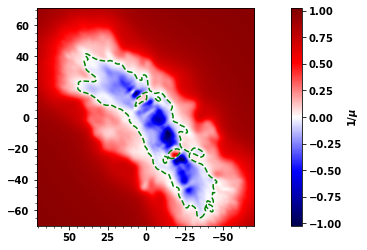

In [3]:
def magnmap(lpot,xrang,yrang):
    ##### Calculates determinant of magn. matrix (detmag) and convergence (kap)
	psix = np.gradient(lpot.T)[0]/(nx/206264.80624709636)
	psiy = np.gradient(lpot.T)[1]/(nx/206264.80624709636)
	psixx = np.gradient(psix)[0]/(nx/206264.80624709636)
	psiyy = np.gradient(psiy)[1]/(nx/206264.80624709636)
	psixy = np.gradient(psix)[1]/(nx/206264.80624709636)
	psiyx = np.gradient(psiy)[0]/(nx/206264.80624709636)
	kap = 0.5*(psixx + psiyy)
	gam1 = 0.5*(psixx - psiyy)
	gam2 = psixy
	kap = kap
	gam1 = gam1
	gam2 = gam2
	detmag = (1.0-kap)*(1.0-kap) - (gam1**2) - (gam2**2)

	return detmag,kap
detmag,avgkap = magnmap(avglpot,xrang,yrang)
# Magnification Map with CC
fig3,ax3=subplots()
im3 = ax3.imshow(detmag,extent=(xlow,xhigh,ylow,yhigh),aspect='auto',cmap='seismic',origin='lower',norm=colors.CenteredNorm())
fig3.colorbar(im3,label=r'$1/\mu$',pad=0.02)
critcurve = ax3.contour(x,y,detmag,levels=[0],colors='g',linestyles='dashed')
ax3.minorticks_on()
ax3.set_aspect('equal')
ax3.set_anchor('C')
plt.xlim(xlow,xhigh)
plt.ylim(ylow,yhigh)

ax3.invert_xaxis()
plt.show()

In [4]:
# To get magnification, you can interpolate the magnification
detmaginterp = RectBivariateSpline(xrang,yrang,detmag.T) # Interpolate Magnification Map

# Then 1/detmaginterp.ev(x,y) will be magnification at point x,y